In [4]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




# Imports

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchinfo import summary

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [90]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#location of the extracted data
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [98]:
print(class_names)

['ants', 'bees']


In [3]:
print(device)

cuda:0


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



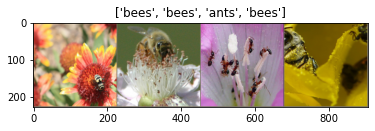

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model (Helper functions)
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [101]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if i == 0 : 
                print(type(inputs))
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                print('True: {}'.format(class_names[label]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




### CoAtNet

In [53]:
from src.models.coatnet import coatnet_0
cnet = coatnet_0()
cnet.fc = nn.Linear(in_features=cnet.fc.in_features, out_features=2, bias=True)
cnet = cnet.to(device=device)
#print(cnet)

criterion = nn.CrossEntropyLoss().to(device=device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(cnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [55]:
batch_size = 4
summary(cnet, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
CoAtNet                                                 --                        --
├─Sequential: 1-1                                       [4, 64, 112, 112]         --
│    └─Sequential: 2-1                                  [4, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [4, 64, 112, 112]         1,728
│    │    └─BatchNorm2d: 3-2                            [4, 64, 112, 112]         128
│    │    └─GELU: 3-3                                   [4, 64, 112, 112]         --
│    └─Sequential: 2-2                                  [4, 64, 112, 112]         --
│    │    └─Conv2d: 3-4                                 [4, 64, 112, 112]         36,864
│    │    └─BatchNorm2d: 3-5                            [4, 64, 112, 112]         128
│    │    └─GELU: 3-6                                   [4, 64, 112, 112]         --
├─Sequential: 1-2                                  

In [54]:
cnet = train_model(cnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9019 Acc: 0.5451
val Loss: 0.7018 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.7401 Acc: 0.5574
val Loss: 0.6375 Acc: 0.6144

Epoch 2/24
----------
train Loss: 0.7363 Acc: 0.5984
val Loss: 0.6046 Acc: 0.6797

Epoch 3/24
----------
train Loss: 0.6778 Acc: 0.6148
val Loss: 0.6010 Acc: 0.7255

Epoch 4/24
----------
train Loss: 0.6093 Acc: 0.6803
val Loss: 0.9495 Acc: 0.6405

Epoch 5/24
----------
train Loss: 0.6808 Acc: 0.6270
val Loss: 0.6909 Acc: 0.6013

Epoch 6/24
----------
train Loss: 0.6589 Acc: 0.6434
val Loss: 0.5638 Acc: 0.7124

Epoch 7/24
----------
train Loss: 0.5905 Acc: 0.6967
val Loss: 0.5753 Acc: 0.7582

Epoch 8/24
----------
train Loss: 0.5745 Acc: 0.6844
val Loss: 0.6096 Acc: 0.7386

Epoch 9/24
----------
train Loss: 0.5455 Acc: 0.7049
val Loss: 0.5893 Acc: 0.7059

Epoch 10/24
----------
train Loss: 0.5678 Acc: 0.7172
val Loss: 0.6119 Acc: 0.7451

Epoch 11/24
----------
train Loss: 0.5329 Acc: 0.7295
val Loss: 0.5779 Acc: 0.7451

Ep

<class 'torch.Tensor'>


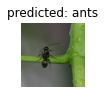

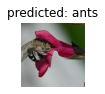

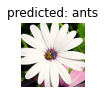

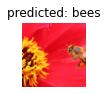

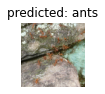

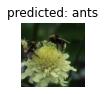

In [102]:
visualize_model(cnet)

### ConvNeXt

In [57]:
convnext = models.convnext_small(pretrained=False)
convnext.classifier[2] = nn.Linear(in_features=convnext.classifier[2].in_features, out_features=2, bias=True)
convnext = convnext.to(device=device)

### Print info
# print(convnext)
# batch_size = 4
# summary(convnext, input_size=(batch_size, 3, 224, 224))

criterion = nn.CrossEntropyLoss().to(device=device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(convnext.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [58]:
summary(convnext, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      --                        --
├─Sequential: 1-1                             [4, 768, 7, 7]            --
│    └─ConvNormActivation: 2-1                [4, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                       [4, 96, 56, 56]           4,704
│    │    └─LayerNorm2d: 3-2                  [4, 96, 56, 56]           192
│    └─Sequential: 2-2                        [4, 96, 56, 56]           --
│    │    └─CNBlock: 3-3                      [4, 96, 56, 56]           79,296
│    │    └─CNBlock: 3-4                      [4, 96, 56, 56]           79,296
│    │    └─CNBlock: 3-5                      [4, 96, 56, 56]           79,296
│    └─Sequential: 2-3                        [4, 192, 28, 28]          --
│    │    └─LayerNorm2d: 3-6                  [4, 96, 56, 56]           192
│    │    └─Conv2d: 3-7                       [4, 192, 28, 28]          73,920

In [59]:
convnext = train_model(convnext, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1725 Acc: 0.4918
val Loss: 0.8597 Acc: 0.5229

Epoch 1/24
----------
train Loss: 1.0878 Acc: 0.5082
val Loss: 0.6985 Acc: 0.5229

Epoch 2/24
----------
train Loss: 1.0235 Acc: 0.5123
val Loss: 0.7274 Acc: 0.5752

Epoch 3/24
----------
train Loss: 0.9047 Acc: 0.5000
val Loss: 0.7186 Acc: 0.5752

Epoch 4/24
----------
train Loss: 0.9321 Acc: 0.4877
val Loss: 0.8560 Acc: 0.4641

Epoch 5/24
----------
train Loss: 1.1145 Acc: 0.5082
val Loss: 0.7684 Acc: 0.5490

Epoch 6/24
----------
train Loss: 1.1131 Acc: 0.5041
val Loss: 0.7372 Acc: 0.5425

Epoch 7/24
----------
train Loss: 0.7063 Acc: 0.5861
val Loss: 0.6822 Acc: 0.5621

Epoch 8/24
----------
train Loss: 0.7052 Acc: 0.5369
val Loss: 0.6811 Acc: 0.5882

Epoch 9/24
----------
train Loss: 0.7323 Acc: 0.4877
val Loss: 0.6949 Acc: 0.5621

Epoch 10/24
----------
train Loss: 0.7216 Acc: 0.5123
val Loss: 0.6909 Acc: 0.5556

Epoch 11/24
----------
train Loss: 0.7397 Acc: 0.5000
val Loss: 0.6989 Acc: 0.5621

Ep

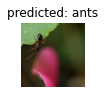

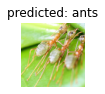

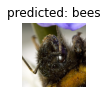

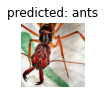

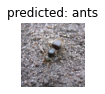

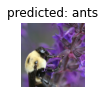

In [60]:
visualize_model(convnext)

### ViTb32

In [61]:
vitb32 = models.vit_b_32(pretrained=False)
vitb32.heads.head = nn.Linear(in_features=vitb32.heads.head.in_features, out_features=2, bias=True)
vitb32 = vitb32.to(device=device)

### Print info
# print(vitb32)
# batch_size = 4
# summary(vitb32, input_size=(batch_size, 3, 224, 224))

criterion = nn.CrossEntropyLoss().to(device=device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vitb32.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [62]:
summary(vitb32, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                                            Output Shape              Param #
VisionTransformer                                                 --                        --
├─Conv2d: 1-1                                                     [4, 768, 7, 7]            2,360,064
├─Encoder: 1-2                                                    [4, 50, 768]              --
│    └─Dropout: 2-1                                               [4, 50, 768]              --
│    └─Sequential: 2-2                                            [4, 50, 768]              --
│    │    └─EncoderBlock: 3-1                                     [4, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-2                                     [4, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-3                                     [4, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-4                                     [4, 50, 768]              7,087,872
│    │    

In [63]:
vitb32 = train_model(vitb32, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4746 Acc: 0.4795
val Loss: 0.8944 Acc: 0.5817

Epoch 1/24
----------
train Loss: 1.0071 Acc: 0.5205
val Loss: 0.6652 Acc: 0.5948

Epoch 2/24
----------
train Loss: 0.8503 Acc: 0.5902
val Loss: 0.6606 Acc: 0.5948

Epoch 3/24
----------
train Loss: 0.9746 Acc: 0.5574
val Loss: 1.7679 Acc: 0.5556

Epoch 4/24
----------
train Loss: 0.7414 Acc: 0.6189
val Loss: 0.7738 Acc: 0.5490

Epoch 5/24
----------
train Loss: 0.6464 Acc: 0.6516
val Loss: 1.4546 Acc: 0.5621

Epoch 6/24
----------
train Loss: 0.7702 Acc: 0.6393
val Loss: 0.8872 Acc: 0.6013

Epoch 7/24
----------
train Loss: 0.5904 Acc: 0.6926
val Loss: 0.6473 Acc: 0.6340

Epoch 8/24
----------
train Loss: 0.5146 Acc: 0.7254
val Loss: 0.6068 Acc: 0.6863

Epoch 9/24
----------
train Loss: 0.5729 Acc: 0.6926
val Loss: 0.6750 Acc: 0.6144

Epoch 10/24
----------
train Loss: 0.5546 Acc: 0.7172
val Loss: 0.6099 Acc: 0.6863

Epoch 11/24
----------
train Loss: 0.4981 Acc: 0.7418
val Loss: 0.6204 Acc: 0.6993

Ep

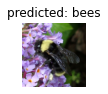

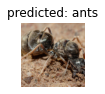

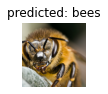

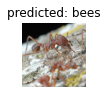

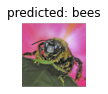

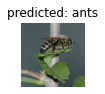

In [64]:
visualize_model(vitb32)

### Resnet 50

In [65]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [66]:
summary(model_ft, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [4, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [4, 64, 112, 112]         128
├─ReLU: 1-3                              [4, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [4, 64, 56, 56]           --
├─Sequential: 1-5                        [4, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [4, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [4, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [4, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [4, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [4, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [4, 64, 56, 56]           --
│ 

In [67]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4959 Acc: 0.4877
val Loss: 51.8435 Acc: 0.5425

Epoch 1/24
----------
train Loss: 3.1334 Acc: 0.5574
val Loss: 2.3358 Acc: 0.5490

Epoch 2/24
----------
train Loss: 1.8673 Acc: 0.5123
val Loss: 1.3974 Acc: 0.5752

Epoch 3/24
----------
train Loss: 0.9586 Acc: 0.5984
val Loss: 0.9859 Acc: 0.6536

Epoch 4/24
----------
train Loss: 1.1343 Acc: 0.5779
val Loss: 2.0958 Acc: 0.5425

Epoch 5/24
----------
train Loss: 1.1306 Acc: 0.5615
val Loss: 8.4396 Acc: 0.4706

Epoch 6/24
----------
train Loss: 0.8892 Acc: 0.5287
val Loss: 1.5889 Acc: 0.5556

Epoch 7/24
----------
train Loss: 0.6943 Acc: 0.5492
val Loss: 0.9199 Acc: 0.6601

Epoch 8/24
----------
train Loss: 0.6770 Acc: 0.5615
val Loss: 3.5434 Acc: 0.4444

Epoch 9/24
----------
train Loss: 0.6466 Acc: 0.6148
val Loss: 1.2122 Acc: 0.5425

Epoch 10/24
----------
train Loss: 0.6440 Acc: 0.6639
val Loss: 0.7704 Acc: 0.6275

Epoch 11/24
----------
train Loss: 0.6745 Acc: 0.6230
val Loss: 4.7752 Acc: 0.5098

E

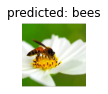

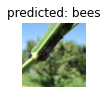

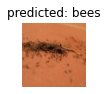

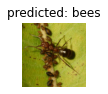

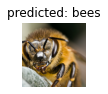

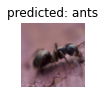

In [68]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





# HuggingFace Tutorial

[Installation](https://huggingface.co/docs/transformers/installation).
Only version 4.17.0 has ConvNext Model
`pip install transformers==4.17.0`
`conda install -c huggingface transformers==4.17.0`
`conda install -c conda-forge transformers==4.17.0`

## Sentiment analysis Test
`python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"`

In [1]:
from transformers import ConvNextModel, ConvNextConfig

# Initializing a ConvNext convnext-tiny-224 style configuration
configuration = ConvNextConfig()
# Initializing a model from the convnext-tiny-224 style configuration
model = ConvNextModel(configuration)
# Accessing the model configuration
configuration = model.config

In [ ]:
from transformers import ConvNextFeatureExtractor, ConvNextModel
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")
model = ConvNextModel.from_pretrained("facebook/convnext-tiny-224")

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

# ConvNext from source
`git clone https://github.com/facebookresearch/ConvNeXt`
`pip install timm==0.3.2 tensorboardX six`

# CLIP

In [204]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

#location of the extracted data
data_dir = 'data/hymenoptera_data'
image_datasets_clip = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#loads the PIL image into tensor
dataloaders_clip = {x: torch.utils.data.DataLoader(image_datasets_clip[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [173]:
#see an example image of an ant
import random

print(random.sample(range(len(image_datasets_clip['val'])), 10))


[43, 151, 116, 138, 47, 121, 131, 135, 101, 139]


In [187]:
for i ,x in dataloaders_clip['val']:
    print(i.shape)
    break


torch.Size([1, 3, 224, 224])


In [239]:
def visualize_model_clip(model,processor, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (image, label) in enumerate(dataloaders_clip['val']):
            #change image datatype to correct jpg
            #print(image.size)
            inputs = processor(
                text=class_names, images=image[0], return_tensors="pt", padding=True
            )
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
            _, preds = torch.max(probs, 1)
            
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds]))
            print('True: {}'.format(class_names[label]))
            plt.imshow(transforms.ToPILImage()(image[0]))
            plt.pause(0.001)  # pause a bit so that plots are updated
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
        model.train(mode=was_training)

True: bees


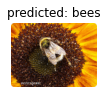

True: ants


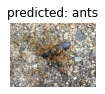

True: bees


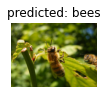

True: ants


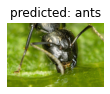

True: bees


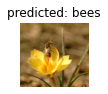

True: ants


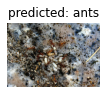

In [240]:
visualize_model_clip(model,processor)

In [209]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
#image = image_datasets_clip['val'][100][0]
for i ,x in dataloaders_clip['val']:
    inputs = processor(
        text=["ants", "bees"], images=i, return_tensors="pt", padding=True
    )
    break


outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [225]:
transforms.ToPILImage()(i[0]).show()

In [208]:
print(probs)

tensor([[0.0062, 0.9938]], grad_fn=<SoftmaxBackward0>)


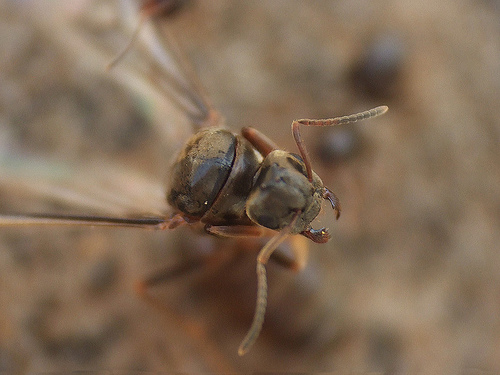

In [148]:
image

In [97]:
print(inputs)

{'input_ids': tensor([[49406,  2368, 49407],
        [49406,  1929, 49407]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1]]), 'pixel_values': tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1

In [75]:
print(image)
image.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x26FA090D6D0>


In [217]:
_, pred = torch.max(probs, 1)
print(pred)

tensor([0])


In [220]:
ll = [9, 4]
print(ll[pred])

9
